<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#LLMGPS:-map-reads-to-contigs" data-toc-modified-id="LLMGPS:-map-reads-to-contigs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LLMGPS: map reads to contigs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#config" data-toc-modified-id="config-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sandbox</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Check that the contigs actually match the reads provided via the CAMI2 repo

# Var

In [1]:
work_dir = '/ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS/'

# Init

In [14]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(LeyLabRMisc)
Init(threads = 8)

# LLMGPS: map reads to contigs

* Mapping reads to contigs to make sure that contigs were derived from those reads
  * All contigs should have reads mapped (coverage >= ~1X at each position)

### config

In [5]:
F = file.path(work_dir, 'config.yaml')
cat_file(F)

#-- I/O --#
# table with sample --> read_file information
samples_file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS/samples.tsv

# table of reference genomes; not needed for all analyses (see README.md)
genomes_db: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS/contigs_n1.tsv
genomes_cols:  
  taxon_col: 'taxon'
  fasta_col: 'fasta'
  accession_col: 'accession'
  taxid_col: 'taxid'  

# output location
output_dir: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

# read file path
# use "None" if full file path is included in the samples_file
read_file_path: None

#-- clades to analyze with strainphlan --#
clades:
 - s__Faecalibacterium_prausnitzii
 - s__Bacteroides_vulgatus
 - s__Methanobrevibacter_smithii

#-- subsample --#
# subsampling input reads 
## Use "Skip" to skips subsampling; otherwise

### Run

```
(snakemake) rick: /tmp/global2/nyoungblut/code/dev/ll_pipelines/llmgps
$ screen -L -S llmgps-test ./snakemake_sge.sh /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS/config.yaml 30 
```

## Summary

In [34]:
# finding all individual depth files
D = file.path(work_dir, 'bowtie2', 'depth')
depth_files = list_files(D, '*.tsv.gz')
depth_files %>% length
depth_files %>% head(n=3)

[1] 100

[1] "/ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_0.tsv.gz" 
[2] "/ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_1.tsv.gz" 
[3] "/ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_10.tsv.gz"

In [ ]:
# loading files
read_depth = function(F){
    message('Reading file: ', F)
    dt = Fread(F, header=FALSE) %>%
        summarize.(n_pos = n.(),
                   mean_depth = mean(V3),
                   sd_depth = sd(V3),
                   num_zero = sum(V3 == 0),
                   .by = c(V1)) %>%
        mutate.(stderr_depth = sd_depth / sqrt(n_pos),
                frac_zero = num_zero / n_pos,
                V1 = gsub('.+__', '', V1)) %>%
        rename.('contig' = V1)
    dt$target = F %>% dirname %>% basename %>% gsub('.+_sample', 'sample', .)
    dt$query = F %>% basename %>% gsub('.+_(sample_[0-9]+)\\.tsv\\.gz', '\\1', .)
    return(dt)
}

depths = depth_files %>%
    lapply(read_depth) %>%
    rbindlist(use.names=TRUE)
depths

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_0.tsv.gz

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_1.tsv.gz

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_10.tsv.gz

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_11.tsv.gz

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/2017_12_04_18_45_54_sample_12.tsv.gz

Reading file: /ebio/abt3_projects/databases_no-backup/CAMI/CAMI2_HMP-gut/short_read/LLMGPS//bowtie2/depth/2017_12_04_18_45_54_sample_0/20

In [40]:
# contig coverage
summary_x(depths$mean_depth)
summary_x(depths$sd_depth)
summary_x(depths$stderr_depth)
summary_x(depths$frac_zero)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
mean_depth,2.678702e-05,1.083032,2.567568,6.261953,6.875,430.472,10.728,4.38


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
sd_depth,0,0.8704879,1.700486,3.125295,3.679246,251.3945,4.2,1.714


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
stderr_depth,0,0.03008536,0.05626396,0.1170904,0.1276386,14.28793,0.178,0.073


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
frac_zero,0,0.01807229,0.110984,0.2062181,0.3386621,0.9999732,0.235,0.096


In [43]:
# contigs lacking mapped reads
depths %>%
    mutate.(query = gsub('\\.tsv.gz', '', query)) %>%
    filter.(target == query) %>%
    filter.(frac_zero > 0.25) %>%
    distinct.(contig)

[1] 2391515

contig
<chr>
CONTIG3
CONTIG11
⋮
CONTIG14348
CONTIG14380


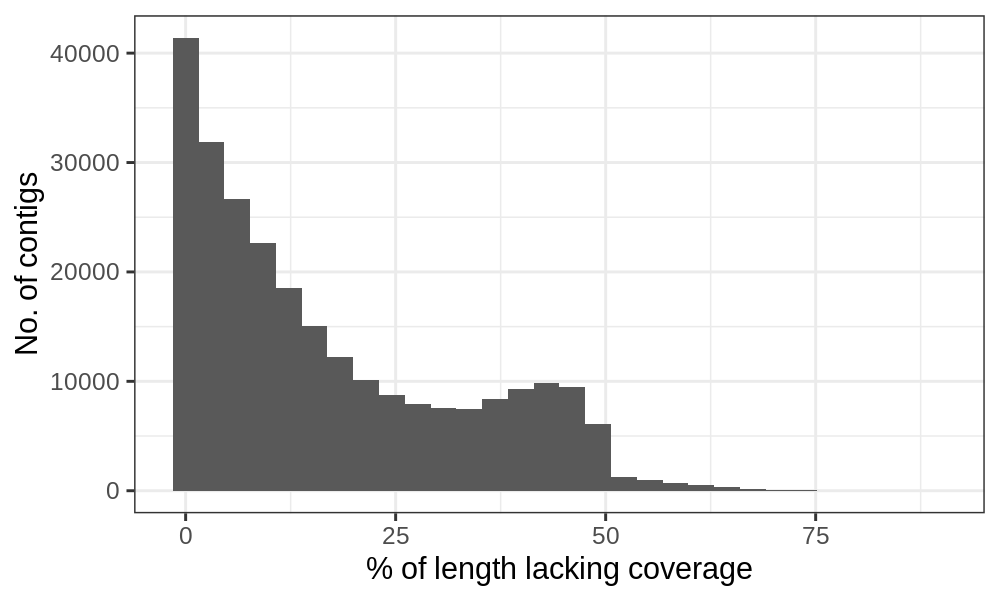

In [48]:
# contigs lacking mapped reads
p = depths %>%
    mutate.(query = gsub('\\.tsv.gz', '', query)) %>%
    filter.(target == query) %>%
    mutate.(frac_zero = frac_zero * 100) %>%
    ggplot(aes(frac_zero)) +
    geom_histogram(bins=30) +
    labs(x='% of length lacking coverage',
         y='No. of contigs') +
    theme_bw()
p.dims(5,3)
plot(p)

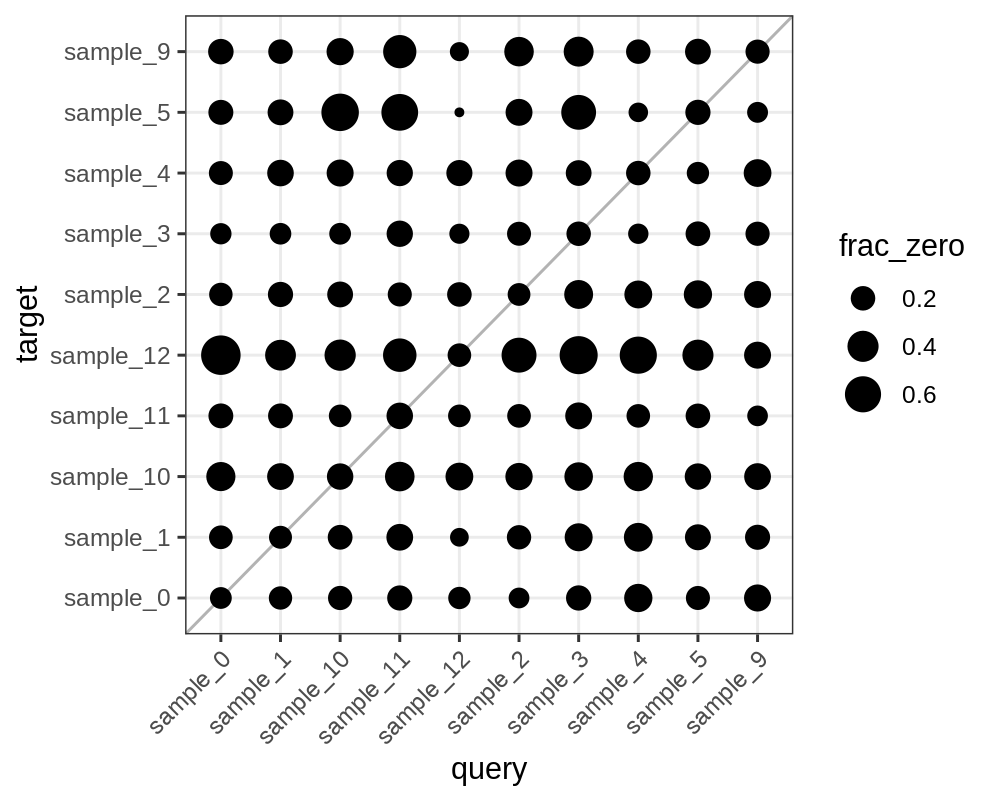

In [53]:
# plotting
p = depths %>%
    mutate.(query = gsub('\\.tsv.gz', '', query),
            query = gsub('.+_sample', 'sample', query)) %>%
    summarize.(frac_zero = mean(frac_zero),
               .by = c(target, query)) %>%
    ggplot(aes(query, target, size=frac_zero)) +
    geom_abline(alpha=0.3) +
    geom_point() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
p.dims(5,3.5)
plot(p)

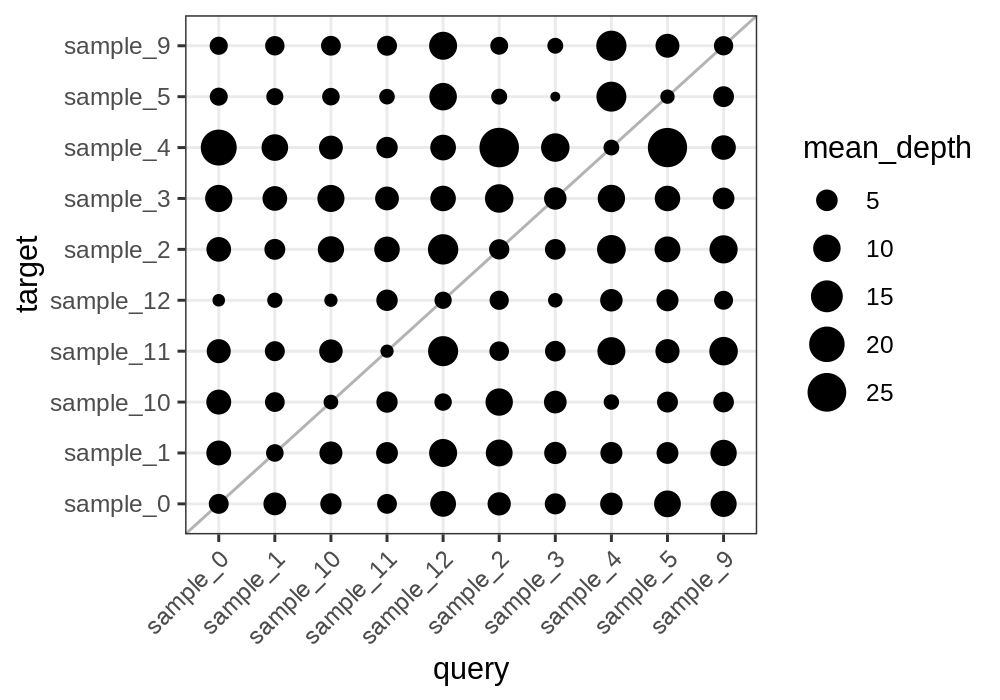

In [75]:
 # plotting
p = depths %>%
    mutate.(query = gsub('\\.tsv.gz', '', query),
            query = gsub('.+_sample', 'sample', query)) %>%
    summarize.(mean_depth = mean(mean_depth),
               .by = c(target, query)) %>%
    ggplot(aes(query, target, size=mean_depth)) +
    geom_abline(alpha=0.3) +
    geom_point() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
p.dims(5,3.5)
plot(p)

In [67]:
# for each target, which query has highest mean depth
df.dims(20)
depths %>%
    mutate.(query = gsub('\\.tsv.gz', '', query),
            query = gsub('.+_sample', 'sample', query)) %>%
    summarize.(frac_zero = mean(frac_zero),
               mean_depth = mean(mean_depth),
               .by = c(target, query)) %>%
    mutate.(rankA = dense_rank(-mean_depth),
            rankB = dense_rank(frac_zero),
            .by = c(target)) %>%
    arrange.(rankB, rankA) %>%
    slice_head.(n=20)

target,query,frac_zero,mean_depth,rankA,rankB
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>
sample_1,sample_12,0.08434782,10.556575,1,1
sample_11,sample_9,0.11668057,11.102862,2,1
sample_4,sample_5,0.14992391,25.966816,2,1
sample_5,sample_12,0.01755560,10.046824,2,1
sample_9,sample_12,0.08978945,10.554240,2,1
sample_0,sample_2,0.11844730,6.204527,4,1
sample_10,sample_5,0.24980520,4.532734,5,1
sample_3,sample_12,0.10702675,8.132961,5,1
sample_12,sample_12,0.17798861,2.586347,6,1


In [ ]:
send_email('http://127.0.0.1:9704/notebooks/version2/deepmased/notebooks/06_version2/01_simulation_datasets/04_CAMI/02b_CAMI2_HMP-gut_contig-check.ipynb')

# sessionInfo

In [54]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /tmp/global2/nyoungblut/code/general/conda_envs/general-tidyverse/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] clustermq_0.8.95.2 LeyLabRMisc_0.2.1  tidytable_0.6.6    data.table_1.14.2 
[5] ggplot2_3.3.5      tidyr_1.1.4        dplyr_1.0.7       

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7        plyr_1.8.6        pillar_1.6.4      compiler_4.1.1   
 [5] R.metho